# Language Detection
## by Juan Pablo Ortega, Jorge Salgado and Deivid Toloza
In this notebook, we present a program that detects if a given text is in English or in Spanish based on a rough probability model.

## Prerequisites and libraries

In [177]:
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from unidecode import unidecode
import pandas as pd
pd.set_option('display.max_rows',500)
import numpy as np
#note that we did not use any ML library

#read text from file
def read_file(filename: str)->str:
    with open(filename, 'r',encoding="utf-8") as file:
        content = file.read()
    return unidecode(content)


## Defining the model
Our model is pretty simple: We count the amount of times that each letter occurs in the text 'Cien años de soledad' and we build an histogram based on these frequencies. That histogram is latter used as an estimation of the likelihood of occurance of each letter in the text T whose language we want to identify, and will be used as an estimation of how likely is that the text T is in Spanish. After that, we multiply the 'Spanish likelihood' of each of the letters that indeed apear in the text T (assuming independence between them), to get our Spanish likehood of text T. We do the same process to build an estimation how likely is that the text T is in English, only this time we use the book 'To kill a mockingbird' as training text. We then compare both likehood and determine which language is more plausible that the text T is written in. 

In [178]:
#save text string in variab
short_story_spanish:str = read_file("gabriel_garcia_marquez_cien_annos_soledad.txt")
short_story_english:str = read_file("to_kill_a_mockingbird.txt")

### Chosen texts
The reason to choose 'Cien años de soledad' and 'To kill a mockingbird' is that these two books share some important characteristics: They are both novels that have beetween 100k and 150k words, they were written in the 60s (relatively recently), they are literature classics of their respetive countries and they both address social issues. With this, we wanted to avoid bias in the model; for example, choosing an older text as 'El Quijote' could cause problems because Spanish has evolved a lot since Cervantes (Words like 'Hierro' and 'Hermosa' used to be written as 'Fierro' and 'Fermosa', changing the distribution). We believe that these two texts are good fits for the model, specially when put together, but one could conduct a study to evaluate how the model performance changes with other trainig texts.

## Building the model

In [179]:
#create dictionary with word count
def get_character_count(s: str)->dict:
    all_characters = string.ascii_lowercase
    character_count:dict  = {}
    for character in all_characters:
        character_count[character] = s.count(character)
    return character_count

def get_number_of_characters(s: str)->int:
    return len(s.replace(" ", ""))

def normalize_probabilities(character_count: int, total_characters: int)->float:
    return character_count/total_characters
    
def get_character_probabilities(character_count: dict, text:str)->dict:
    character_probabilities = {}
    n_characters = get_number_of_characters(text)
    print(character_count.keys())
    for char in character_count.keys():
        character_probabilities[char] = normalize_probabilities(character_count[char], n_characters)
    return character_probabilities


def graph_character_likelihood(character_probabilities: dict, title:str):
    plt.bar(range(len(character_probabilities)), list(character_probabilities.values()), align='center')
    plt.xticks(range(len(character_probabilities)), list(character_probabilities.keys()))
    plt.title(title)
    plt.grid(False)
    plt.show()


In [180]:
#unit test
def check_probabilities_sum(propabilities: dict)->bool:
    p_sum = 0
    for p in propabilities.keys():
        p_sum = propabilities[p]
    sum_eq_one = p_sum == 1
    if sum_eq_one:
        print("Sum of probabilities is NOT Equal to 1.")
    else:
        print("Sum of probabilities is Equal to 1.")
    return sum_eq_one

    

## English likelihood distribution

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
Sum of probabilities is Equal to 1.


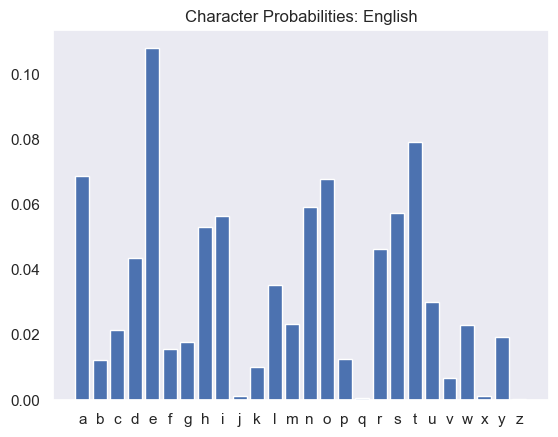

In [181]:
EN_dist = get_character_count(short_story_english)
EN_dist = get_character_probabilities(EN_dist,short_story_english)
check_probabilities_sum(EN_dist)
#Plotting the normalized distribution of the english story:
graph_character_likelihood(EN_dist, "Character Probabilities: English")



## Spanish likelihood distribution

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
Sum of probabilities is Equal to 1.


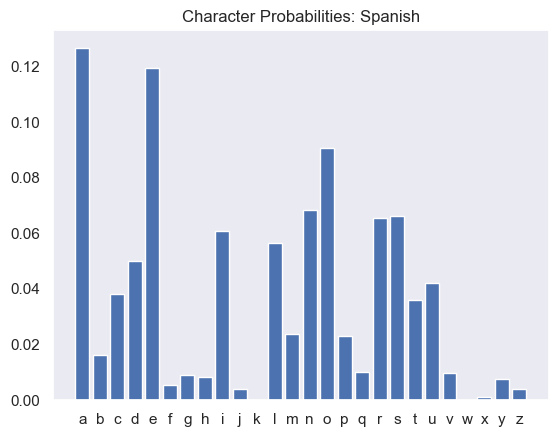

In [182]:
ES_dist = get_character_count(short_story_spanish)
ES_dist = get_character_probabilities(ES_dist,short_story_spanish)
check_probabilities_sum(ES_dist)
#Plotting the normalized distribution of the english story:
graph_character_likelihood(ES_dist, "Character Probabilities: Spanish")

## Model core and likelihood comparison

In [183]:
def get_clean_text(text:str)->str:
  all_characters = string.ascii_lowercase
  uppercase_character = string.ascii_uppercase
  character_list = list(text)

  for char in character_list:
    if char in uppercase_character:
      text = text.replace(char, char.lower())
    elif char not in all_characters:
      text = text.replace(char, "")
  return text

def language_identifier(text:str):

    prob_EN = 0
    prob_ES = 0
    clean_text = get_clean_text(text)
    for character in clean_text:
      prob_EN = prob_EN + math.log(EN_dist[character]+0.0001)
      prob_ES = prob_ES + math.log(ES_dist[character]+0.0001)
    if prob_EN>prob_ES:
      return 'English'
    else:
      return 'Spanish'


## Testing phase
Now that the model is ready, we will test it with a dataset of more that 2000 sentences in English and Spanish to see how well it performs. The data used can be found in https://www.kaggle.com/datasets/basilb2s/language-detection.

In [184]:
df = pd.read_csv('Language Detection.csv') #importing the data
df

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada


In [185]:
dfing = df[df.Language=='English'] #Filtering the data so we have only Spanish and English
dfesp = df[df.Language=='Spanish']
df2   = pd.concat([dfing,dfesp])
df2

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
5624,¿Tiene ella?,Spanish
5625,Supongo que no querría más pan de oro ahora ¿e...,Spanish
5626,"Terry, en realidad te pareces un poco a ese án...",Spanish
5627,¿Cómo pudiste ser él?,Spanish


In [186]:
#It's test day!
CorrectES = 0
CorrectEN = 0
FailsES   = 0
FailsEN   = 0
for i in range(0,2204):
    pred = language_identifier(df2.iloc[i,0])
    if (pred == df2.iloc[i,1]) and (pred == 'Spanish'):
        CorrectES+=1
    elif (pred == df2.iloc[i,1]) and (pred == 'English'):
        CorrectEN +=1
    elif (df2.iloc[i,1]=='Spanish'):
        FailsES +=1
    else:
        FailsEN +=1



## Results

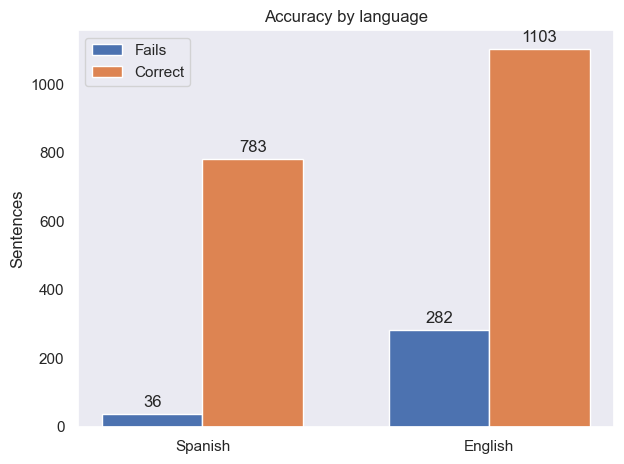

 Spanish accuracy: 0.9560439560439561 
 English accuracy: 0.7963898916967509 
 Total accuracy:   0.8557168784029038


In [187]:
labels = ['Spanish', 'English']
men_means = [FailsES, FailsEN]
women_means = [CorrectES, CorrectEN]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.grid(False)
rects1 = ax.bar(x - width/2, men_means, width, label='Fails')
rects2 = ax.bar(x + width/2, women_means, width, label='Correct')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentences')
ax.set_title('Accuracy by language')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

print(" Spanish accuracy:", CorrectES/(CorrectES+FailsES),
      "\n English accuracy:", CorrectEN/(CorrectEN+FailsEN),
      "\n Total accuracy:  ", (CorrectEN+CorrectES)/(CorrectES+CorrectEN+FailsEN+FailsES))

## Analysis and conclusion
We can see that the model identified the language with a decent accuracy, specially considering its simplicity. A posible explanation for the specially remarkable performance with the Spanish sentences is the larger lenght of 'Cien años de soledad' compared to 'To kill a mockingbird'; it could also be possible that Spanish has a more 'recognisable syntax' when compared to English. Addionally, in the future, the model could be expanded by adding more languages.

Overall, it is nice and refreshing to see a language detector model that does not use machine learning and still performs decently. It would be interesting to compare its performance with one of a ML model and keep pushing the frontiers of the language detection world.